# Digital downconverter for demodulating and digitally filter a signal

### Import Libraries

In [1]:
#Load the libraries
import numpy as np #math libraty
import matplotlib.pyplot as plt #plot library
import Labber #Labber library for data handling 
from scipy import optimize #fit function
from scipy.signal import butter,filtfilt, resample #Filter for downconversion

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

### Digital downconversion

From a signal
$$S=I\cos(\omega_0t)+Q\sin(\omega_0 t)=V_1+V_2 $$

(basically the time traces returned by the digitizer $\mathbf{ V}_i$ with $i=1,2$).

Digital demodulation of each trace:

$$ \mathbf{ X_i} = \mbox{LPFilter}[  \mathbf{V}_i\cos(\omega_{IF} t) ]$$
$$ \mathbf{ P_i} = \mbox{LPFilter}[  \mathbf{V}_i\sin(\omega_{IF} t) ]$$

Combining the trace in a complex output:

$$A_i = X_i + i P_i$$

Combining the two traces (check signs!)

$$A = X_1 + P_2 + i(X_2-P_1)$$

In [2]:
def demodulationIQ(samRate, IF, LowPassFreq,  VI, VQ):
    if len(VI)!=len(VQ):
        print('Error: I and Q need to have the same length!')
    points=len(VI)
    timeTrace=np.linspace(0,1/samRate*points, points)
    C=np.cos(timeTrace*2*np.pi*IF)
    S=np.sin(timeTrace*2*np.pi*IF)
    X1=VI*C
    P1=VI*S
    X2=VQ*C
    P2=VQ*S
    nyq=samRate/2
    normal_cutoff = LowPassFreq / nyq
    b,a=butter(2, normal_cutoff, 'lowpass', analog=False, output='ba')
    X1_new = filtfilt(b, a, X1)
    X2_new = filtfilt(b, a, X2)
    P1_new = filtfilt(b, a, P1)
    P2_new = filtfilt(b, a, P2)
    A=X1_new+P2_new+1j*(X2_new-P1_new)
    return A

def demodulation(samRate, IF, LowPassFreq,  VI):
    points=len(VI)
    timeTrace=np.linspace(0,1/samRate*points, points)
    C=np.cos(timeTrace*2*np.pi*IF)
    S=np.sin(timeTrace*2*np.pi*IF)
    X1=VI*C
    P1=VI*S
    nyq=samRate/2
    normal_cutoff = LowPassFreq / nyq
    b,a=butter(2, normal_cutoff, 'lowpass', analog=False, output='ba')
    X1_new = filtfilt(b, a, X1)
    P1_new = filtfilt(b, a, P1)
    A=X1_new-1j*P1_new
    return A


### Import data

In [4]:
#import data file

#FOLDER=r'Q:\\DataArchive\\18-31-BF-4C-39-1E'  #speedy
#DATA_PATH=r'\2020\\05\Data_0513\\Time_domain_switching_Yoko2V_AWG1V_square50us_2.hdf5'
#PATH= FOLDER+DATA_PATH

#read measurement
file=Labber.LogFile('Time_domain_switching_Yoko2V_AWG1V_square50us_2.hdf5')
#print('Imported data from: ', PATH)

In [5]:
#check the channel that has been logged 
log_channels = file.getLogChannels()
print('\nThere are', len(log_channels),'log channels:')
for i in range(len(log_channels)):
    print(i, ") ", log_channels[i]['name'])

#read the sweeps 
step_channels = file.getStepChannels()
print('\nThere are', len(step_channels),'step channels:')
for i in range(len(step_channels)):
    print(step_channels[i]['name'])
sweep_steps=0
for i in range(len(step_channels)):
    if len(step_channels[i]['values'])>1:
        sweep_steps+=1
print('There are ', sweep_steps, 'sweeps:')
for i in range(sweep_steps):
    print(i,')',step_channels[i]['name'], ':', step_channels[i]['values'])

#print(step_channels)
entryN=file.getNumberOfEntries()

print('\nThere are', entryN, 'entries.')



There are 4 log channels:
0 )  Pulse Generator - Voltage, QB1
1 )  Keithley 2000 Multimeter - Value
2 )  Dig - Ch1 - Signal
3 )  Dig - Ch2 - Signal

There are 16 step channels:
Manual - Repeat
awg slot3 - Ch1 - Offset
awg slot3 - Ch2 - Offset
Dig - Number of samples
Dig - Number of averages
trigger - Trig period
Signal frequency
IF
Pulse Generator - Amplitude #1
Pulse Generator - Readout amplitude
Pulse Generator - Readout duration
Pulse Generator - Readout frequency #1
Signal Source 19 (WG) - Frequency
SA - Center frequency
SA - Span
Yoko2 - Voltage
There are  1 sweeps:
0 ) Manual - Repeat : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]

There are 1 entries.


In [6]:
#save important variables
for i in range(len(step_channels)):
    if step_channels[i]['name']=="Manual - Repeat":
        repeatValues=step_channels[i]['values']

DataVoltageI=file.getData(2)
DataVoltageQ=file.getData(3)

### Manipulating the data and taking averages or slices

In [7]:
#averaging over repeat
VoltageI=np.average(DataVoltageI, axis=0)
VoltageQ=np.average(DataVoltageQ, axis=0)

In [8]:
SamplingRate=500.0e6 #Digitizer sampling rate
IF=100.0e6           #Sideband frequency used
LowPassFreq=1e6      #frequency below which we want to keep them

#Calculating the demodulation
demodulatedIQ=demodulationIQ(SamplingRate, IF,LowPassFreq , VoltageQ, VoltageI)
demodulated=demodulation(SamplingRate, IF,LowPassFreq , VoltageQ)

C:\Users\scmarco\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


### Plotting 

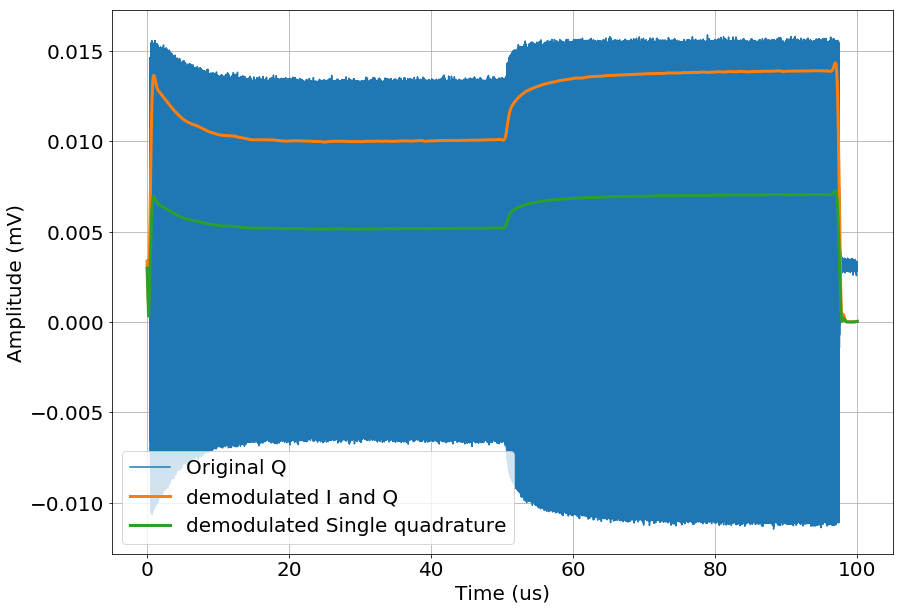

In [9]:
timeTrace=np.linspace(0, len(demodulated.real)/SamplingRate, len(demodulated.real))

plt.figure(figsize=(14,10))
#plt.plot(timeTrace/1e6, VoltageI, label='Original I')
plt.plot(timeTrace/1e-6, VoltageQ, label='Original Q')
plt.plot(timeTrace/1e-6, np.abs(demodulatedIQ), label='demodulated I and Q', lw=3)
plt.plot(timeTrace/1e-6, np.abs(demodulated), label='demodulated Single quadrature', lw=3)
plt.xlabel('Time (us)', fontsize=20)
plt.ylabel('Amplitude (mV)', fontsize=20)
#plt.xlim((0.2e-10,0.4e-10))
plt.legend(fontsize=20)
plt.grid(True)